In [ ]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import re
from torchvision.transforms import functional as F
from torchvision.ops.boxes import box_iou
import random
import torchvision
import warnings
from xml.etree import ElementTree

!pip install --upgrade albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e .
from ranger import Ranger  
%cd ..
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed = 42)

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


## To Do Right Now: 

# Counting bboxes and getting statistics. Look at project ideas

# Do the OCR functionality

# Do the Pytorch mAP pycocotools

# Work on semi supervised learning

# Improve accuracy by including this in noise loader
https://www.kaggle.com/gpiosenka/a-large-set-of-balls

# Test inference of each class on images and video. maybe turn iou off on video. 



# Paper

### Move to .py script




In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Fruit Defects DatasetPeaches .zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("/content/drive/MyDrive/noisy_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)
freshApples_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplebtch2label/FreshApplesBatch2LabelsFresh.csv", header = None)
freshApples_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplesBatch1Labels/FreshAppleBatch1Labels.csv", header = None)
rottenTomato_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/Rotten TomatoBatch1/Batch1TomoatosLabelsBbox.csv", header = None)
rottenTomato_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottnTomatoBatch2/RottenTomatyoBatch2Labelss.csv", header = None)
rottenTomato_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottenTomatBtch3/RottenTomatoesBatch3Labssles.csv", header = None)
rottenTomato_csv_batch_4 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottenTomatoesBatch4/Tomatobatch4labelssRotten.csv", header = None)
freshTomato_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Fresh Tomatoes/FreshTomatoesBatch1Labelss/FreshTomatoesLabelsBatch1Labels.csv", header = None)
freshTomato_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Fresh Tomatoes/FreshTomatBatch2Labessls/Batch2TomatlabelsFresh.csv", header = None)
rottenPeach_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Peaches/Bctch1RottenPeachesLabels/RottenPeachesBatch1Labelks.csv", header = None)
rottenPeach_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Peaches/RottenPeachesBatch2lbeLabels/Batch2PeahcesRottenLabels.csv", header = None)
freshPeach_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Peaches/Batch1FreshPeaches/freshpeahcheslabelsbatch1.csv", header = None)
freshPeach_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Peaches/Batch2FreshPeache/Batch2FreshPeachesLabels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_3.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_4.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshTomato_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshTomato_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenPeach_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenPeach_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshPeach_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshPeach_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
freshTomato_csv_batch_1.drop(freshTomato_csv_batch_1[freshTomato_csv_batch_1["Image_id"] == "Fresh Tomatoes66AddonPart1.jpeg"].index, inplace = True)

strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)
freshTomato_csv_batch_1 = freshTomato_csv_batch_1.reset_index(drop = True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3, freshApples_csv_batch_2, freshApples_csv_batch_1, rottenTomato_csv_batch_1, 
                          rottenTomato_csv_batch_2, rottenTomato_csv_batch_3, rottenTomato_csv_batch_4, freshTomato_csv_batch_1, 
                          freshTomato_csv_batch_2, rottenPeach_csv_batch_1, rottenPeach_csv_batch_2, freshPeach_csv_batch_1, freshPeach_csv_batch_2]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))

def run_dataframe_check(after_mis = True):
  assert total_row_sum_check == fruit_df.shape[0]
  if after_mis:
    print("DataFrame shape: {}".format(fruit_df.shape))
    print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
    print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))

run_dataframe_check(after_mis = False)

#Specify more image types when 
def more_specific_Image_id(image_id, fruit):
  if fruit == "Bad_Spots":
    if re.search("RottenStrawberries", image_id):
      return "Strawberry_Bad_Spot"
    elif re.search("RottenApples", image_id):
      return "Apple_Bad_Spot"
    elif re.search("Rotten Tomatoes", image_id):
      return "Tomato_Bad_Spot"
    elif re.search("Rotten Peaches", image_id):
      return "Peaches_Bad_Spot"
    else:
      raise ValueError("Could not find a match for some of the Image_ids")

  else:
    return fruit

def fix_fruitdf_mistakes(fruit):

  if fruit == "Peach ":
    return "Peach"
  else:
    return fruit

# fruit_df["Fruit"] = fruit_df.apply(lambda row: more_specific_Image_id(row.Image_id, row.Fruit), axis = 1)
fruit_df["Fruit"] = fruit_df.apply(lambda row: fix_fruitdf_mistakes(row.Fruit), axis = 1)

run_dataframe_check()

#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

bounding_box_dict = dict()
labels_dict = dict()
# classes = ["Placeholder", "Apples", "Strawberry", "Peach", "Tomato", "Apple_Bad_Spot", "Strawberry_Bad_Spot", "Peaches_Bad_Spot", "Tomato_Bad_Spot"]
classes = ["Placeholder", "Apples", "Strawberry", "Peach", "Tomato", "Bad_Spots"]
# classes = ["Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
print(classes)
# classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))



Checked total rows from all the dataframes combined: 2345
DataFrame shape: (2345, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots' 'Tomato' 'Peach']
Number of Unique Images 644
['Placeholder', 'Apples', 'Strawberry', 'Peach', 'Tomato', 'Bad_Spots']
643
643


# Open Image Data

In [ ]:
!pip install openimages
from openimages.download import download_dataset
#https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F03k3r
download_dataset("/content/", ["Apple", "Peach",'Strawberry','Tomato'], annotation_format="pascal")

## Class function + util functions

In [7]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode, noisy_dataset_path = None, open_image_dir = None, class_list = classes):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    if noisy_dataset_path:
      self.noisy_fp = [fp for fp in glob.glob(os.path.join(noisy_dataset_path, "*.JPEG"))]
      print("Noisy Has been subsetted")
      #Go to this code if you want to subset.
      self.noisy_fp = self.noisy_fp[:40]
    else:
      print("Dataset getting configured without noise loader")
      self.noisy_fp = list()
    
    self.open_image_info = list()
    self.OI_classes = [name.lower() for name in class_list]

    # np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
      if open_image_dir:
        for folder_categ in open_image_dir:
          temporary_info = [fp for fp in glob.glob(os.path.join(folder_categ, "pascal" , "*.xml"))]
          # For open images it is actually xml files
          self.imgs_key.extend(temporary_info)
          self.open_image_info.extend(temporary_info)
      if noisy_dataset_path:
        print("Extended {} noisy images to train set".format(int(len(self.noisy_fp) * 0.8)))
        self.imgs_key.extend(self.noisy_fp[:int(len(self.noisy_fp) * 0.8)])
    elif (mode == "test"):
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]
      if noisy_dataset_path:
        print("Extended {} noisy images to test set".format(int(len(self.noisy_fp) * 0.2)))
        self.imgs_key.extend(self.noisy_fp[int(len(self.noisy_fp) * 0.8):])
    else:
      raise ValueError("Invalid Mode choose from train or test")

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_key = self.imgs_key[idx]
    if img_key in self.noisy_fp:
      img_path = img_key
      boxes = torch.zeros((0, 4), dtype=torch.float32)
      labels = torch.as_tensor([], dtype = torch.int64)
    elif img_key in self.open_image_info:
      # img key is an xml file here

      xml_doc = ElementTree.parse(img_key)
      annotation_root = xml_doc.getroot()

      img_path = annotation_root.find("path").text
      bounding_box_nodes = xml_doc.findall("object/bndbox")
      labels_node = xml_doc.findall("object/name")  

      boxes, labels = list(), list()

      for node in bounding_box_nodes:
        xmax = node.find("xmax").text
        xmin = node.find("xmin").text
        ymax = node.find("ymax").text
        ymin = node.find("ymin").text

        boxes.append([int(xmin), int(ymin), int(xmax), int(ymax)])
      
      for node in labels_node:
        label = self.OI_classes.index(node.text) 
        labels.append(label)
      
      boxes = torch.as_tensor(boxes, dtype = torch.float32)
      labels = torch.as_tensor(labels, dtype = torch.int64)

    else:
      img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
      boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
      labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }

      sample = self.transforms(**sample)
      img = sample['image']

      if img_key not in self.noisy_fp:
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [8]:
#The Drawing function.
# COLORS = [(255, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0)]
COLORS = [(0, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0), (255, 0, 0)]

def draw_boxes(boxes, labels, image, infer = False, put_text = True):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    if infer:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i] % len(COLORS)]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        if put_text:
          cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                      lineType=cv2.LINE_AA)
    return image

# Albumentations
def get_transforms(mode):
  if (mode == "train"):
    return A.Compose([
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      # A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), p=1),
                      # ToTensor(),
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "test"):
    return A.Compose([
                      # A.Resize(512, 512), 
                      # A.Normalize(mean=(0.485, 0.456, 0.406),
                      # std=(0.229, 0.224, 0.225), p=1),
                      # ToTensor()
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "effdet_train"):
    return A.Compose([
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      A.Resize(height = 512, width=512), 
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "effdet_test"):
    return A.Compose([
                      A.Resize(height = 512, width = 512), 
                      ToTensorV2()])
  else:
    raise ValueError("mode is wrong value can either be train or test")

class NoiseDataset(object):

  def __init__(self, noise_file_path, size, camera_size):

    self.size = size
    self.noise_file_path = [fp for fp in glob.glob(os.path.join(noise_file_path, "*.JPEG"))]
    self.transforms = transforms.Compose([
                                          transforms.Resize((camera_size, camera_size)), 
                                          transforms.ToTensor()])
  
  def __getitem__(self, idx):

    current_file_path = self.noise_file_path[idx]
    img = Image.open(current_file_path).convert("RGB")

    img = self.transforms(img)
    return img

  def __len__(self):
    if self.size:
      return self.size
    return len(self.noise_file_path)
    

#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

train_batch_size = 2
test_batch_size = 2
noise_path = "/content/noisy_dataset"
open_image_dir = ["content/apple", "/content/peach", "/content/strawberry", "/content/tomato" ]

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "train"), mode = "train", noisy_dataset_path=noise_path, open_image_dir = None)                               
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)
# Change dataset code

test_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "test"), mode = "test", noisy_dataset_path=noise_path)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True, collate_fn= collate_fn)

noise_dataset = NoiseDataset(noise_path, 100, 512)
noise_loader = torch.utils.data.DataLoader(noise_dataset, batch_size = test_batch_size, shuffle = True)


Noisy Has been subsetted
Extended 32 noisy images to train set
Noisy Has been subsetted
Extended 8 noisy images to test set


2021-06-28  19:09:00 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-06-28  19:09:00 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


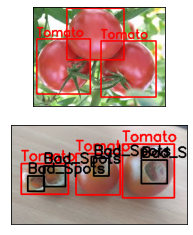

In [44]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(2):
    ax = fig.add_subplot(2, 2/2, idx+1, xticks=[], yticks=[])
    image = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx])
    plt.imshow(image)

## What we learned
is that the model outputs losses when in train mode 
when in model.eval model, the model code then return only a prediction with no losses.

In [34]:
def calculate_metrics(target_box,predictions_box,scores, device):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    iou_mat = iou_mat.cpu().to(torch.double)
    iou_mat = iou_mat.where(iou_mat> 0.5,torch.tensor(0., dtype = torch.double))
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()

    mAP = tp / (tp+fp)
    mAR = tp / (tp+fn)

    return mAP, mAR

def run_metrics_for_batch(output, targets, mAP, mAR, missed_images, device):
  for pos_in_batch, image_pred in enumerate(output):
    assert (len(image_pred["boxes"]) == len(image_pred["labels"]) == len(image_pred["scores"]))
    if len(image_pred["boxes"]) != 0:
      curr_mAP, curr_mAR = calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
  
  return mAP, mAR, missed_images

# def run_metrics_for_effdet_batch(scores, classification, transformed_anchors, targets, mAP, mAR, missed_images, device):
#     assert (len(scores) == len(classification) == len(transformed_anchors))
#     if len(transformed_anchors) != 0:
#       curr_mAP, curr_mAR = calculate_metrics(targets[0][:, :4], transformed_anchors, scores, device)
#       mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
#     else:
#       missed_images += 1 
      
#     return mAP, mAR, missed_images


In [38]:
def train(net, epochs, train_loader, test_loader, noise_loader, lr, weight_decay, 
          print_every = 6, lo_test_dataset = len(test_dataset), lo_train_dataset = len(train_dataset),
          lo_noise_dataset = len(noise_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calculate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]

    # optimizer = Ranger(net.parameters(), lr = lr, weight_decay= weight_decay)
    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            net.train()

            steps += 1
            
            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            for b in range(len(targets)):
              targets[b]["boxes"] = targets[b]["boxes"].type(torch.float)
              targets[b]["area"] = targets[b]["area"].type(torch.float)

            optimizer.zero_grad()

            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            net.eval()
            train_mAP, train_mAR, missed_train_images = run_metrics_for_batch(net(images), targets, train_mAP, train_mAR, missed_train_images, device)
            net.train()
            
            losses.backward()
            # optimizer.step()

            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.first_step(zero_grad = True)

            loss_dict = net(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()

            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.second_step(zero_grad = True)

            train_loss +=  losses.item()
            scheduler.step()

            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = correct_missed_images = 0

                for noise_images in noise_loader:

                  net.eval()
                  if device == torch.device("cuda"):
                    noise_images = [noise_image.to(device) for noise_image in noise_images]
                  
                  output = net(noise_images)

                  for ii in range(len(output)):
                    if len(output[ii]["boxes"]) == 0:
                      correct_missed_images += 1

                for images, targets in test_loader:

                  net.eval()
                  if device == torch.device("cuda"):
                    images = [image.to(device) for image in images]
                    targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

                  for b in range(len(targets)):
                     targets[b]["boxes"] = targets[b]["boxes"].type(torch.float)
                     targets[b]["area"] = targets[b]["area"].type(torch.float)

                  output = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_batch(output, targets, test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  test_loss_dict = net(images, targets)
                  test_losses = sum(loss for loss in test_loss_dict.values())
                  test_loss += test_losses.item()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch {}/{} | Batch Number: {} | LR: {:0.5f} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Missed Test Images: {} | Seperate Noise Loader: {} / {}".format(
                    epoch + 1, epochs, steps, learning_rate_extract, train_loss, test_loss,  
                    (test_mAP / float(lo_test_dataset)) * 100.,missed_test_images,
                    correct_missed_images, lo_noise_dataset))

              assert (steps % print_every) == 0
              train_loss = 0
                 
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))

    return net

# The Mobile Net Model

In [37]:
torch.set_default_dtype(torch.float)
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
backbone.roi_heads.box_predictor.cls_score.out_features = len(classes) 
backbone.roi_heads.box_predictor.bbox_pred.out_features = 4 * (len(classes))
# backbone.roi_heads.box_predictor.cls_score.out_features = 3
# backbone.roi_heads.box_predictor.bbox_pred.out_features = 12


In [39]:
another_one_1 = train(backbone, 20, train_loader, test_loader, noise_loader, 0.0005, weight_decay = 1e-3, print_every = 60)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    adaptive: False
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.0005
    k: 6
    lr: 0.0005
    rho: 0.05
    step_counter: 0
    weight_decay: 0.001
)
Epoch 1/20 | Batch Number: 60 | LR: 0.00050 | Train_loss: 149.54 | Test_loss: 93.02 | Test mAP: 21.72% | Missed Test Images: 0 | Seperate Noise Loader: 3 / 100
Epoch 1/20 | Batch Number: 120 | LR: 0.00050 | Train_loss: 64.69 | Test_loss: 61.37 | Test mAP: 23.06% | Missed Test Images: 2 | Seperate Noise Loader: 23 / 100
Epoch 1/20 | Batch Number: 180 | LR: 0.00050 | Train_loss: 63.13 | Test_loss: 65.75 | Test mAP: 22.72% | Missed Test Images: 1 | Seperate Noise Loader: 28 / 100
Epoch 1/20 | Batch Number: 240 | LR: 0.00050 | Train_loss: 44.89 | Test_loss: 44.09 | Test mAP: 21.48% | Missed Test Images: 1 | Seperate Noise Loader: 28 / 100

 

In [ ]:
another_one_1 = train(backbone, 20, train_loader, test_loader, noise_loader, 0.0005, weight_decay = 1e-3, print_every = 60)

In [ ]:
#Save Model weights: 
# torch.save(another_one_1.state_dict(), "another_one.pth")
# torch.save(another_one_1.state_dict(), "only_bad_spot.pth")

#Load weights: 
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
backbone.roi_heads.box_predictor.cls_score.out_features = len(classes) 
backbone.roi_heads.box_predictor.bbox_pred.out_features = 4 * (len(classes))

backbone.load_state_dict(torch.load("/content/another_one.pth"))

<All keys matched successfully>

In [46]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def intersect(box_a, box_b):

    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard_iou(box_a, box_b):

    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

def calculate_iou_on_label(results, len_of_results, iou_thresh, device):
  for current_index, _ in enumerate(results["boxes"]):
    if current_index >= len_of_results:
      break

    current_index_iou = jaccard_iou(results["boxes"][current_index].view(1, -1).to(device),
                                    results["boxes"].to(device))
    
    mask = (current_index_iou > iou_thresh) & (current_index_iou != 1)
    mask = mask.squeeze()
    for key in results:
      results[key] = results[key][~mask]

    len_of_results -= sum(mask)
  
  return results

def get_labels_categ(classes, want):
  fruit_index_list, bad_spot_index_list = list(), list()
  for ii, name in enumerate(classes):
    if re.search("Spot", name):
      bad_spot_index_list.append(ii)
    elif re.search("Placeholder", name):
      continue
    else:
      fruit_index_list.append(ii)
  
  if want == "fruit":
    return fruit_index_list
  elif want == "bad_spot":
    return bad_spot_index_list
  else:
    raise ValueError("want Type not applicable [fruit or bad_spot only]")

print(classes)
get_labels_categ(classes, "bad_spot")

['Placeholder', 'Apples', 'Strawberry', 'Peach', 'Tomato', 'Bad_Spots']


[5]

In [112]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, webcam = False, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  if not webcam:
    torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
    trained_model.to(device)
    trained_model.eval()
    print("Image Size: {}".format(torch_image.size()))

    start_time = time.time()
    results = trained_model(torch_image)
    end_time = time.time() - start_time

    print("Time of Inference {:0.2f}".format(end_time))
  else:

    torch_image = F.to_tensor(image_file_path).unsqueeze(1).to(device)

    results = trained_model(torch_image)

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  
  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  #This is where I place the order of the list
  fruit_spot_iou_thresh, bad_spot_iou_thresh = iou_thresh

  #Update when I get more data of fruits and when running for script beware of classes.
  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label in get_labels_categ(classes, "bad_spot")]
  fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

  bad_spot_results, fruit_results = dict(), dict()

  for key in results[0]:
    bad_spot_results[key], fruit_results[key] = results[0][key][[bad_spot_index]], results[0][key][[fruit_index]]

  assert len(bad_spot_results["boxes"]) == len(bad_spot_results["scores"]) == len(bad_spot_results["labels"])
  assert len(fruit_results["boxes"]) == len(fruit_results["scores"]) == len(fruit_results["labels"])

  len_of_bad_spots, len_of_fruit = len(bad_spot_results["boxes"]), len(fruit_results["boxes"])

  if len_of_bad_spots > 1:
    bad_spot_results = calculate_iou_on_label(bad_spot_results, len_of_bad_spots, bad_spot_iou_thresh, device)
  if len_of_fruit > 1:
    fruit_results = calculate_iou_on_label(fruit_results, len_of_fruit, fruit_spot_iou_thresh, device)
  
  for key in results[0]: 
    if (key == "boxes"):
      results[0]["boxes"] = torch.cat((fruit_results["boxes"], bad_spot_results["boxes"]), axis = 0)
    else:
      results[0][key] = torch.cat((fruit_results[key], bad_spot_results[key]), dim = 0)

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    written_image = cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True, put_text= True), cv2.COLOR_BGR2RGB)
    plt.imshow(written_image)

  voice_over = develop_voice_over(results, classes)
  print(voice_over)
  
  return results

2021-06-28  20:10:45 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: torch.Size([1, 3, 225, 300])
Time of Inference 0.02
The single Tomato has 19% of surface spoilage. 


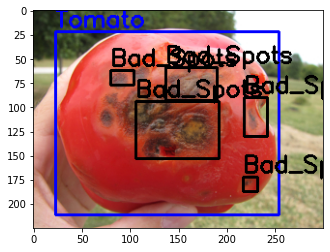

In [121]:
results = infer_image("/content/tomatpred.jpg", backbone, 0.35, [0.5, 0])

# Building User Interface 

# Makes sure code can handle detected bad spots within badspots

In [116]:
def get_label2index(model_out, classes):

  bad_spot_index = classes.index("Bad_Spots")

  label2index = dict()
  for ii, pred_label in enumerate(model_out[0]["labels"]):
    pred_label = int(pred_label)
    if pred_label != bad_spot_index or pred_label != 0:
      if pred_label in label2index:
        label2index[pred_label].append(ii)
      else:
        label2index[pred_label] = [ii]
  
  return label2index

def find_order_of_fruits(model_out, label2index):

  fruit_indices = list()
  for key, value in label2index.items():
    if key != 0 and key != 5:
      fruit_indices.extend(value)

  fruit_bboxes = model_out[0]["boxes"][fruit_indices]
  if len(fruit_bboxes) > 4:
    return None, ("Too Many fruits in view to give a descriptive analysis")

  ii2xmin = dict()
  ii2ymin = dict()
  for ii, bbox in enumerate(fruit_bboxes):
    other_bboxes = torch.cat((fruit_bboxes[:ii], fruit_bboxes[(ii + 1):]), 0)
    iou = jaccard_iou(bbox.unsqueeze(0), other_bboxes)
    if torch.sum(iou > 0.8):
      return None, ("Fruits are too close together to analyze. Please spread them out")
    else:
      ii2xmin[ii] = bbox[0]
      ii2ymin[ii] = bbox[1]

  hor, vert = list(ii2xmin.values()), list(ii2ymin.values())
  hor, vert = torch.stack(hor).detach().cpu().numpy(), torch.stack(vert).detach().cpu().numpy()

  chosen_rep = (ii2xmin if np.var(hor) > np.var(vert) else ii2ymin)
  return sorted(chosen_rep, key = chosen_rep.get), ("horizontal" if np.var(hor) > np.var(vert) else "vertical")

def find_bad_spot_pix_percent(model_out, fruit_order, orientation, classes):

  bad_spot_indices = np.setdiff1d(np.arange(len(model_out[0]["boxes"])), fruit_order)

  spoiled_percentages = list()
  for num in fruit_order:
    fruit_bbox = model_out[0]["boxes"][num]
    area = 0
    for bd_index in bad_spot_indices:
      bad_spot_bbox = model_out[0]["boxes"][bd_index]
      if (fruit_bbox[0] < bad_spot_bbox[0] and
          fruit_bbox[1] < bad_spot_bbox[1] and
          fruit_bbox[2] > bad_spot_bbox[2] and
          fruit_bbox[3] > bad_spot_bbox[3]):
        area += (bad_spot_bbox[2] - bad_spot_bbox[0]) * (bad_spot_bbox[3] - bad_spot_bbox[1])
    
    fruit_area = (fruit_bbox[2] - fruit_bbox[0]) * (fruit_bbox[3] - fruit_bbox[1])
    if area > fruit_area:
      area = fruit_area

    spoiled_percentages.append(int((area / fruit_area * 100)))

  voice_over = str()

  if len(fruit_order) == 1:
    fruit_name = classes[model_out[0]["labels"][fruit_order[0]]]
    voice_over = "The single {} has {}% of surface spoilage. ".format(
           fruit_name, 
          spoiled_percentages[0]
      )
    return voice_over

  if orientation == "vertical":
    for ii, num in enumerate(fruit_order):
      fruit_name = classes[model_out[0]["labels"][num]]
      if ii == 0:
        voice_over = "The {} that is the top most fruit has {}% of surface spoilage. ".format(
            fruit_name, 
            spoiled_percentages[ii]
        )
      else:
        voice_over += "The {} that is {} below the top most fruit has {}% of surface spoilage. ".format(
            fruit_name, 
            ii, 
            spoiled_percentages[ii]
        )   
  else:
    for ii, num in enumerate(fruit_order):
      fruit_name = classes[model_out[0]["labels"][num]]
      if ii == 0:
        voice_over = "The {} that is the left most fruit has {}% of surface spoilage. ".format(
            fruit_name, 
            spoiled_percentages[ii]
        )
      else:
        voice_over += "The {} that is {} right to the left most fruit has {}% of surface spoilage. ".format(
            fruit_name, 
            ii, 
            spoiled_percentages[ii]
        )  

  return voice_over 

def develop_voice_over(model_out, classes):

  if len(model_out[0]["labels"]) == 0:
    # Check if there are any predictions
    return None

  label2index = get_label2index(model_out, classes)
  fruit_order, orientation = find_order_of_fruits(model_out, label2index)

  if not fruit_order:
    # Check if you can find order
    return orientation
  
  voice_over = find_bad_spot_pix_percent(model_out, fruit_order, orientation, classes)
  return voice_over
  

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      /* try changing the capture canvas and see what happens*/
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [ ]:
data_transforms = get_transforms(mode = "test")

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 

color=None
label=None
line_thickness=None
another_one.to(device).eval();
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)
    prediciton = infer_image(image, another_one, 0.03, [0.3, 0.1], webcam= True, show_image = False)

    drawing_array = np.zeros([512,512,4], dtype=np.uint8)

    for x in prediciton[0]['boxes']:

      tl = line_thickness or round(0.002 * (drawing_array.shape[0] + drawing_array.shape[1]) / 2) + 1  # line/font thickness
      color = color or [random.randint(0, 255) for _ in range(3)]
      c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
      cv2.rectangle(drawing_array, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
      if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(drawing_array, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(drawing_array, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))

    img_data = drawing_bytes

<IPython.core.display.Javascript object>